<a href="https://colab.research.google.com/github/Sirczechs-Kaustubh/Finance-Sentiment-Analysis/blob/main/BNP_Paribas_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary of Cells:
1. **Install Dependencies & Initialize**: Install all necessary libraries, initialize the News API, and set up some styles.
2. **Fetch Articles**: Provide the date range selector to fetch news articles between two dates.
3. **Sector & Sentiment Assignment**: Classify articles into sectors and analyze their sentiment using a pre-trained model.
4. **All Sectors Time Series Plot**: Use a date selector to visualize sentiment trends for all sectors over time.
5. **Single Sector Time Series Plot**: Provide sector and date selectors to visualize sentiment trends for a specific sector.
6. **Violin Plot**: Display sentiment score distributions for different sectors.
7. **Top 3 Positive and Negative Sentiment Scoring Sectors**: Display top positive and negative sectors by weighted sentiment score in a bar chart.
8. **Sentiment Scores vs Index**: Displays a graph showcasing the correlation between Sentiment Scores and the S&P 500 Index corresponding to the dates.
9. **Granger Causality Test**: Determines if the Sentiment Scores have the capability of predicting the movements of S&P 500 Index.



## 1. Installing and Importing Required Packages

In [ ]:
# Install necessary libraries
!pip install newsapi-python transformers ipywidgets statsmodels --quiet

# Import required libraries
from google.colab import output
output.enable_custom_widget_manager()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from transformers import pipeline
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn as sns
import re
from matplotlib.dates import DateFormatter
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests


# Set default style for Seaborn
sns.set_style('whitegrid')

# Initialize News API with your API key
newsapi = NewsApiClient(api_key='c69a8005d32d45dcaec0f947955152c6')  # Replace with your NewsAPI key

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00


## 2. Acquire Data

In [3]:
# Function to fetch articles for a specific date
def fetch_articles(date):
    all_articles = newsapi.get_everything(
        q='US recession OR recession fears',
        from_param=date.strftime('%Y-%m-%d'),
        to=date.strftime('%Y-%m-%d'),
        language='en',
        sort_by='relevancy',
        page_size=100,
    )
    return all_articles['articles']

# Function to collect articles between a start and end date
def collect_articles(start_date, end_date):
    date_list = pd.date_range(start=start_date, end=end_date)
    articles_data = []

    for date in date_list:
        print(f"Fetching articles for {date.date()}")
        articles = fetch_articles(date)
        for article in articles:
            articles_data.append({
                'date': date.date(),
                'title': article['title'],
                'description': article['description'],
                'content': article['content'],
            })
    return pd.DataFrame(articles_data)

# Download S&P 500 historical data from yfinance
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    sp500['Return'] = sp500['Adj Close'].pct_change()  # Calculate daily returns
    sp500 = sp500[['Return']].dropna()  # Drop rows where returns are NaN
    return sp500

# Date picker widgets for selecting the start and end dates
start_date_widget = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=datetime.now() - timedelta(days=30)
)
end_date_widget = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=datetime.now()
)

# Display the date picker widgets
print("Please select the start and end dates for fetching articles.")
display(start_date_widget, end_date_widget)

# Wait for the user to select the dates
input("Press Enter after selecting dates...")

start_date = start_date_widget.value
end_date = end_date_widget.value

# Fetch the articles
articles_df = collect_articles(start_date, end_date)

# Fetch S&P 500 data for the same date range as the sentiment analysis articles
sp500_data = get_sp500_data(start_date, end_date)

# Combine title, description, and content into a single text column
def preprocess_text(row):
    text = ''
    if row['title']:
        text += row['title'] + '. '
    if row['description']:
        text += row['description'] + '. '
    if row['content']:
        text += row['content']
    return text

articles_df['text'] = articles_df.apply(preprocess_text, axis=1)


Please select the start and end dates for fetching articles.


DatePicker(value=datetime.datetime(2024, 9, 21, 0, 19, 16, 424620), description='Start Date')

DatePicker(value=datetime.datetime(2024, 10, 21, 0, 19, 16, 459166), description='End Date')

Press Enter after selecting dates...
Fetching articles for 2024-09-21
Fetching articles for 2024-09-22
Fetching articles for 2024-09-23
Fetching articles for 2024-09-24
Fetching articles for 2024-09-25
Fetching articles for 2024-09-26
Fetching articles for 2024-09-27
Fetching articles for 2024-09-28
Fetching articles for 2024-09-29
Fetching articles for 2024-09-30
Fetching articles for 2024-10-01
Fetching articles for 2024-10-02
Fetching articles for 2024-10-03
Fetching articles for 2024-10-04
Fetching articles for 2024-10-05
Fetching articles for 2024-10-06
Fetching articles for 2024-10-07
Fetching articles for 2024-10-08
Fetching articles for 2024-10-09
Fetching articles for 2024-10-10
Fetching articles for 2024-10-11
Fetching articles for 2024-10-12
Fetching articles for 2024-10-13
Fetching articles for 2024-10-14
Fetching articles for 2024-10-15
Fetching articles for 2024-10-16
Fetching articles for 2024-10-17
Fetching articles for 2024-10-18
Fetching articles for 2024-10-19
Fetchi

[*********************100%***********************]  1 of 1 completed


## 3. Sector and Sentiment Mapping

In [4]:
# Define sector keywords
sector_keywords = {
    'Technology': ['technology', 'tech', 'software', 'internet', 'AI', 'cybersecurity'],
    'Energy': ['energy', 'oil', 'gas', 'renewable'],
    'Finance': ['finance', 'bank', 'investment'],
    'Healthcare': ['healthcare', 'pharmaceutical', 'medical'],
    'Consumer Goods': ['retail', 'consumer', 'shopping'],
    'Industrial': ['industrial', 'manufacturing'],
    'Real Estate': ['real estate', 'housing', 'mortgage'],
    'Transportation': ['transportation', 'logistics', 'airlines'],
    'Other': []  # For articles that don't match any sector
}

# Compile sector patterns using regex
sector_patterns = {}
for sector, keywords in sector_keywords.items():
    pattern = r'\b(' + '|'.join([re.escape(keyword.lower()) for keyword in keywords]) + r')\b'
    sector_patterns[sector] = re.compile(pattern)

# Function to identify sectors based on keywords
def identify_sectors(text):
    text_lower = text.lower()
    sectors_found = set()
    for sector, pattern in sector_patterns.items():
        if pattern.search(text_lower):
            sectors_found.add(sector)
    return list(sectors_found) if sectors_found else ['Other']

# Apply the sector identification function
articles_df['sectors'] = articles_df['text'].apply(identify_sectors)

# Sentiment analysis using pre-trained BERT model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    #device = 0
)

texts = articles_df['text'].fillna('').str[:512].tolist()
results = sentiment_pipeline(texts)

# Convert results into a DataFrame
sentiment_results = pd.DataFrame(results)

# Assign sentiment scores and map sentiments
def map_sentiment_label(label):
    return 'Positive' if label == 'NEGATIVE' else 'Negative'

sentiment_results['sentiment'] = sentiment_results['label'].apply(map_sentiment_label)
sentiment_mapping = {'Positive': 1, 'Negative': -1}
sentiment_results['sentiment_score'] = sentiment_results['sentiment'].map(sentiment_mapping)

# Merge sentiments back to the main DataFrame
articles_df['sentiment'] = sentiment_results['sentiment']
articles_df['sentiment_score'] = sentiment_results['sentiment_score']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
sentiment_results.head()

,label,score,sentiment,sentiment_score
0,NEGATIVE,0.999218,Positive,1
1,POSITIVE,0.996926,Negative,-1
2,NEGATIVE,0.994230,Positive,1
3,NEGATIVE,0.549419,Positive,1
4,POSITIVE,0.955339,Negative,-1


## 4. Time Series Plot for All sectors

In [ ]:
# Group by date and sectors to calculate average sentiment score
sector_sentiment = articles_df.explode('sectors').groupby(['date', 'sectors'])['sentiment_score'].mean().reset_index()

# Convert 'date' column to datetime
sector_sentiment['date'] = pd.to_datetime(sector_sentiment['date'])

# Date range widgets for the first plot (all sectors over time)
start_date_picker1 = widgets.DatePicker(description='Start Date', value=sector_sentiment['date'].min().date())
end_date_picker1 = widgets.DatePicker(description='End Date', value=sector_sentiment['date'].max().date())

print("Select date range for all sectors:")
#display(start_date_picker1, end_date_picker1)

# Function to plot sentiment over time for all sectors
def plot_all_sectors_over_time(start_date, end_date):
    if start_date is None or end_date is None:
        print("Please select both start and end dates.")
        return
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered_data = sector_sentiment[
        (sector_sentiment['date'] >= start_date) &
        (sector_sentiment['date'] <= end_date)
    ]

    if filtered_data.empty:
        print("No data available for the selected date range.")
        return

    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=filtered_data,
        x='date',
        y='sentiment_score',
        hue='sectors',
        marker='o',
        palette='tab10'
    )
    plt.title('Sector Sentiment Over Time')
    plt.ylabel('Average Sentiment Score')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Interactive plot for all sectors
interact(plot_all_sectors_over_time, start_date=start_date_picker1, end_date=end_date_picker1)


Select date range for all sectors:


DatePicker(value=datetime.date(2024, 9, 20), description='Start Date')

DatePicker(value=datetime.date(2024, 10, 19), description='End Date')

interactive(children=(DatePicker(value=datetime.date(2024, 9, 20), description='Start Date'), DatePicker(value…

<function __main__.plot_all_sectors_over_time(start_date, end_date)>

## 5. Time Series Analysis for a selected sector

In [ ]:
# Dropdown to select sector and date range
sector_selector_single = widgets.Dropdown(
    options=sorted(sector_sentiment['sectors'].unique()),
    value='Technology',
    description='Sector'
)
start_date_picker2 = widgets.DatePicker(description='Start Date', value=sector_sentiment['date'].min().date())
end_date_picker2 = widgets.DatePicker(description='End Date', value=sector_sentiment['date'].max().date())

print("Select sector and date range for plotting:")
#display(sector_selector_single, start_date_picker2, end_date_picker2)

# Function to plot sentiment over time for a specific sector
def plot_single_sector_over_time(sector, start_date, end_date):
    if not sector or not start_date or not end_date:
        print("Please select sector and date range.")
        return
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered_data = sector_sentiment[
        (sector_sentiment['sectors'] == sector) &
        (sector_sentiment['date'] >= start_date) &
        (sector_sentiment['date'] <= end_date)
    ]

    if filtered_data.empty:
        print(f"No data available for {sector} sector in the selected range.")
        return

    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=filtered_data,
        x='date',
        y='sentiment_score',
        marker='o',
        color='blue'
    )
    plt.title(f'Sentiment Over Time for {sector} Sector')
    plt.ylabel('Average Sentiment Score')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Interactive plot for single sector
interact(plot_single_sector_over_time, sector=sector_selector_single, start_date=start_date_picker2, end_date=end_date_picker2)


Select sector and date range for plotting:


interactive(children=(Dropdown(description='Sector', index=7, options=('Consumer Goods', 'Energy', 'Finance', …

<function __main__.plot_single_sector_over_time(sector, start_date, end_date)>

## 6. Visualisation of Sentiment Distribution

<ipython-input-7-e7c4efad3fee>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


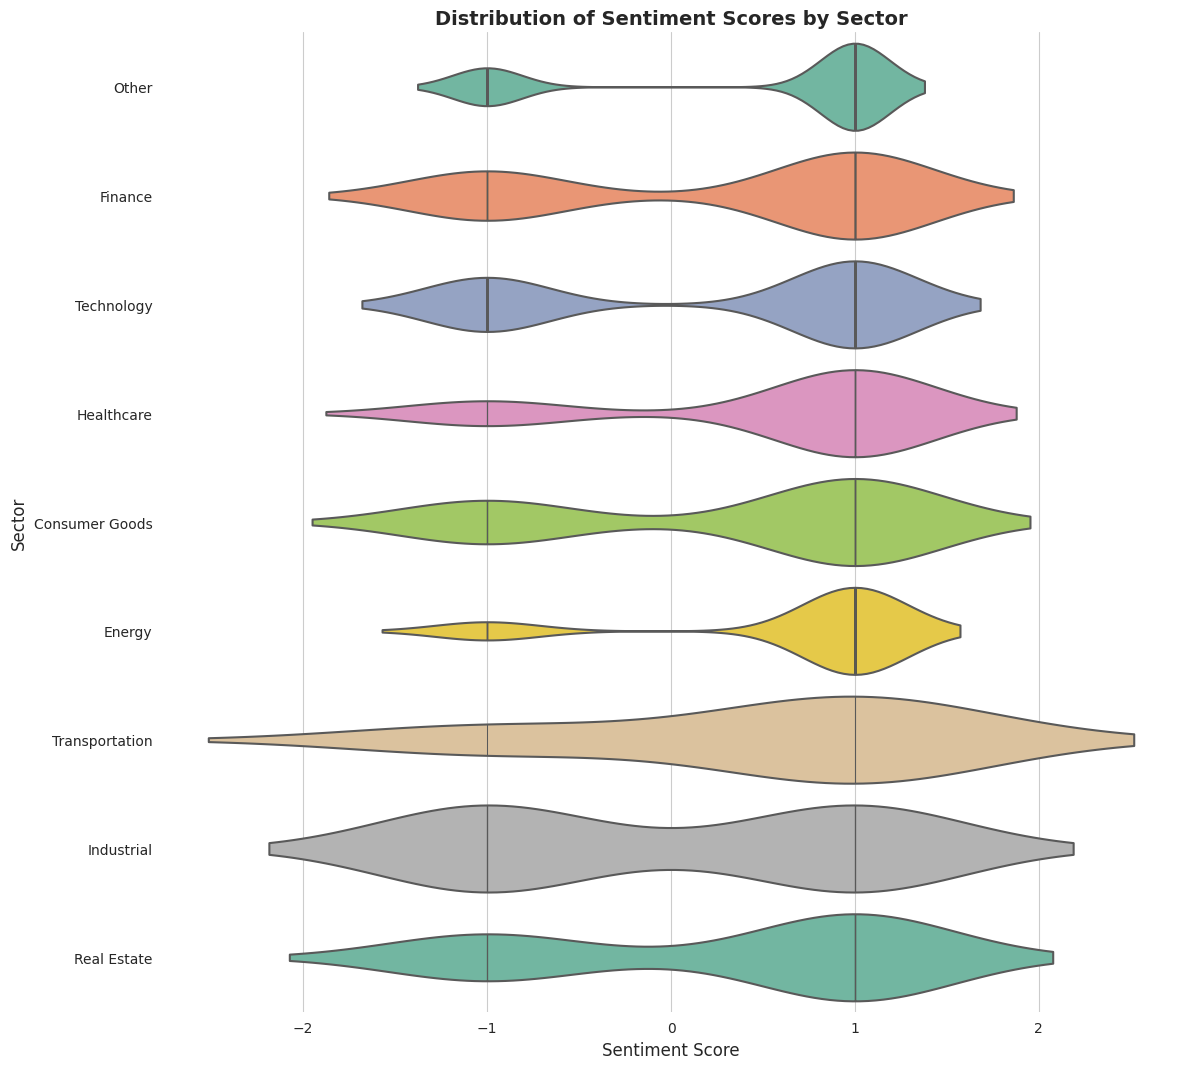

In [ ]:
# Function to plot violin plot for the overall sentiment distribution by sector
def plot_sentiment_violin_fill(data):
    sns.set_style('whitegrid')
    fig_height = 1.2 * len(data['sectors'].unique())

    plt.figure(figsize=(12, fig_height))
    sns.violinplot(
        data=data,
        x='sentiment_score',
        y='sectors',
        inner='stick',
        linewidth=1.5,
        palette='Set2'
    )

    sns.despine(left=True, bottom=True)
    plt.title('Distribution of Sentiment Scores by Sector', fontsize=14, fontweight='bold')
    plt.xlabel('Sentiment Score', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the violin plot using the data from articles_exploded_df
plot_sentiment_violin_fill(articles_df.explode('sectors'))


## 7. High Sentiment Scoring Sector vs Low Sentiment Scoring Sector

In [ ]:
# Widgets for selecting date range for top positive and negative sectors
start_date_picker3 = widgets.DatePicker(
    description='Start Date',
    value=sector_sentiment['date'].min().date()
)
end_date_picker3 = widgets.DatePicker(
    description='End Date',
    value=sector_sentiment['date'].max().date()
)

print("Select date range for top 3 positive and negative sectors:")
#display(start_date_picker3, end_date_picker3)

# Function to plot top 3 positive and top 3 negative sectors
def plot_top_sectors(data, start_date, end_date):
    # Filter data by date range
    if start_date is None or end_date is None:
        print("Please select a date range.")
        return

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered_data = data[
        (data['date'] >= start_date) &
        (data['date'] <= end_date)
    ]

    if filtered_data.empty:
        print("No data available for the selected date range.")
        return

    # Calculate total sentiment score and count for each sector
    sector_stats = filtered_data.groupby('sectors').agg(
        total_sentiment=('sentiment_score', 'sum'),
        count=('sectors', 'size')
    ).reset_index()

    # Calculate weighted sentiment score
    sector_stats['weighted_sentiment'] = sector_stats['total_sentiment'] / sector_stats['count']

    # Sort and extract top 3 positive and top 3 negative sectors
    top_positive = sector_stats.sort_values(by='weighted_sentiment', ascending=False).head(3)
    top_negative = sector_stats.sort_values(by='weighted_sentiment').head(3)

    # Concatenate top positive and negative sectors
    top_sectors = pd.concat([top_positive, top_negative])

    # Define color for positive and negative sectors
    top_sectors['color'] = ['Positive' if x >= 0 else 'Negative' for x in top_sectors['weighted_sentiment']]

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Use different colors for top positive and negative sectors
    sns.barplot(
        x='weighted_sentiment',
        y='sectors',
        data=top_sectors,
        hue='color',
        dodge=False,
        palette={'Positive': 'green', 'Negative': 'red'}  # Green for top 3, Red for bottom 3
    )

    # Add a horizontal line between the top and bottom performers
    plt.axhline(y=2.5, color='black', linestyle='--', linewidth=2)  # Line between the third and fourth bars

    # Customize the plot
    plt.title('Top 3 Positive and Negative Sectors by Weighted Sentiment Score', fontsize=16, fontweight='bold', color='darkblue')
    plt.xlabel('Weighted Sentiment Score', fontsize=14, fontweight='bold', color='darkblue')
    plt.ylabel('Sectors', fontsize=14, fontweight='bold', color='darkblue')
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=False)

    # Customize legend
    plt.legend(title="Sentiment Type", loc="upper right", fontsize=12, title_fontsize=14, frameon=True, shadow=True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Interactive plot for top sectors
interact(
    plot_top_sectors,
    data=fixed(sector_sentiment),
    start_date=start_date_picker3,
    end_date=end_date_picker3
)


Select date range for top 3 positive and negative sectors:


interactive(children=(DatePicker(value=datetime.date(2024, 9, 20), description='Start Date'), DatePicker(value…

<function __main__.plot_top_sectors(data, start_date, end_date)>

## 8. Plot of Sentiment vs S&P 500 Index

Correlation between sentiment and S&P 500 returns: -0.1481


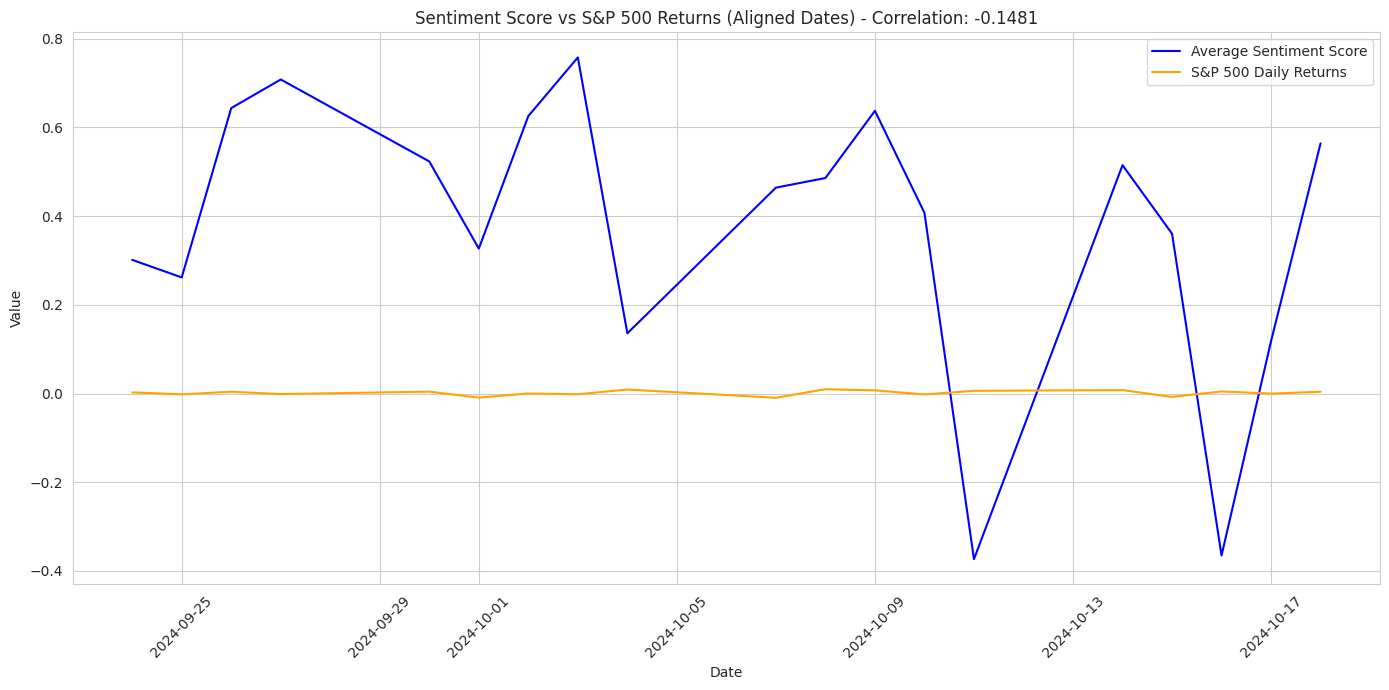

In [ ]:
sector_sentiment['date'] = pd.to_datetime(sector_sentiment['date'])

daily_sentiment = sector_sentiment.groupby('date')['sentiment_score'].mean().reset_index()

merged_data = pd.merge(daily_sentiment, sp500_data, left_on='date', right_index=True, how='inner')

def plot_sentiment_vs_index(merged_data):

    # Step 1: Calculate the correlation
    correlation = merged_data['sentiment_score'].corr(merged_data['Return'])
    print(f"Correlation between sentiment and S&P 500 returns: {correlation:.4f}")

    # Step 2: Plot the time series
    plt.figure(figsize=(14, 7))

    # Plot average sentiment scores
    plt.plot(merged_data['date'], merged_data['sentiment_score'], label='Average Sentiment Score', color='blue')

    # Plot S&P 500 returns (scaled to match sentiment scores)
    plt.plot(merged_data['date'], merged_data['Return'], label='S&P 500 Daily Returns', color='orange')

    plt.title(f'Sentiment Score vs S&P 500 Returns (Aligned Dates) - Correlation: {correlation:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return correlation

correlation_score = plot_sentiment_vs_index(merged_data)

## 8. Time Series Causality Check

In [ ]:
# Check stationarity with Augmented Dickey-Fuller test
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]:.4f}')
    print(f'p-value for {name}: {result[1]:.4f}')
    if result[1] < 0.05:
        print(f"{name} is stationary.")
        return True
    else:
        print(f"{name} is not stationary, differencing is required. \n")
        return False

# Differencing if necessary to make the time series stationary
def make_stationary(series):
    return series.diff().dropna()

# Defining Granger causality test function
def perform_granger_causality(sentiment_series, return_series):
    # Combine the two series into a DataFrame
    df = pd.DataFrame({
        'Sentiment': sentiment_series,
        'Return': return_series
    }).dropna()

    # Determine the maximum lag allowable based on the number of observations
    max_lag = min(4, len(df) // 2)  # Restrict lag based on available observations, cap it at 4
    print(f"Performing Granger causality test with maximum allowable lag of {max_lag}...")

    # Perform Granger causality test
    granger_results = grangercausalitytests(df[['Return', 'Sentiment']], max_lag, verbose=False)

    # Loop over results and extract p-values
    significant_lags = []
    for lag in granger_results:
        p_value = granger_results[lag][0]['ssr_chi2test'][1]  # Extracting p-value
        print(f"Lag {lag}: p-value = {p_value:.4f}")
        if p_value < 0.05:
            significant_lags.append(lag)

    if significant_lags:
        print(f"Granger causality found for lags: {significant_lags}")
    else:
        print("No Granger causality found.")

    return significant_lags


In [ ]:
sentiment_stationary = merged_data['sentiment_score']  # Defaults to original data
returns_stationary = merged_data['Return']  # Defaults to original data

if not check_stationarity(merged_data['sentiment_score'], 'Sentiment Score'):
    sentiment_stationary = make_stationary(merged_data['sentiment_score'])

if not check_stationarity(merged_data['Return'], 'S&P 500 Returns'):
    returns_stationary = make_stationary(merged_data['Return'])

# Performing the Granger causality test
test_result = perform_granger_causality(sentiment_stationary, returns_stationary)

# Checking the results and make a conclusion
if test_result:
    print("Sentiment Scores provide predictive information for future returns.")
else:
    print("Sentiment Scores do not provide predictive information, consider using a different dataset or better keywords.")

ADF Statistic for Sentiment Score: -1.3950
p-value for Sentiment Score: 0.5847
Sentiment Score is not stationary, differencing is required. 

ADF Statistic for S&P 500 Returns: -1.9465
p-value for S&P 500 Returns: 0.3105
S&P 500 Returns is not stationary, differencing is required. 

Performing Granger causality test with maximum allowable lag of 4...
Lag 1: p-value = 0.4198
Lag 2: p-value = 0.9407
Lag 3: p-value = 0.3681
Lag 4: p-value = 0.1017
No Granger causality found.
Sentiment Scores do not provide predictive information, consider using a different dataset.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## 9. Final Report